In [1]:
from privacy_onion.layer_utils import (
    plot_kde,
    tpr_at_fpr,
    plot_roc,
    plot_kde_lira,
    plot_multi_roc,
    plot_kde_custom,
    tpr_at_threshold)

In [2]:

import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
os.chdir("../")
plt.style.use("plot_style.mplstyle")

MODEL_DIR = "trained_models"

In [ ]:
import pickle
path = "/vol/bitbucket/vb524/lossv2/trained_models/layer_target_indices/CIFAR_lira/layer_1_vulnerable.pkl"

vals = pickle.load(open(path, "rb"))
len(vals)


380

## pretrain + finetune w clipping

In [7]:
exp_ids = ["CIFAR_dp_no_multaug", "CIFAR_dp_multaug"]

for exp_id in exp_ids:
    # tpr = tpr_at_fpr(exp_id, fpr=0.001)
    # print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/model", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(saves['hyperparameters'])
    # print(saves['trained_on_indices'])


Accuracy 52.47
{'batchsize': 512, 'epochs': 100, 'lr': 0.1, 'exp_id': 'CIFAR_dp_no_multaug', 'weight_decay': 0.0005, 'momentum': 0.9, 'seed': 2546, 'arch': 'wrn28-2', 'dataset': 'CIFAR10', 'clip_norm': 10.0, 'noise_multiplier': None, 'private': True, 'target_epsilon': 50.0, 'target_delta': 1e-05, 'augment': True, 'checkpoint': False, 'track_free_loss': False, 'track_computed_loss': False, 'track_confidences': False, 'track_grad_norms': False, 'balanced_sampling': True, 'dual': None, 'shadow_count': None, 'shadow_id': None, 'gpu': '', 'model_start': 0, 'model_stop': 1, 'layer': 0, 'layer_folder': '', 'augmult': False, 'selective_clip': False}
Accuracy 88.01
{'batchsize': 512, 'epochs': 100, 'lr': 0.1, 'exp_id': 'CIFAR_dp_multaug', 'weight_decay': 0.0005, 'momentum': 0.9, 'seed': 2546, 'arch': 'wrn28-2', 'dataset': 'CIFAR10', 'clip_norm': 10.0, 'noise_multiplier': None, 'private': True, 'target_epsilon': 50.0, 'target_delta': 1e-05, 'augment': True, 'checkpoint': False, 'track_free_loss'

In [5]:
# exp_ids = [f"CINIC_top5_l{i}" for i in range(0, 7)]

# exp_ids = [f"CINIC_top5_l1"]
exp_ids = ['CIFAR_top5_l0','CIFAR_lira_l1', 'CIFAR_lira_l2']

for exp_id in exp_ids:
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(len(saves['trained_on_indices']))




  attack  tpr_at_fpr_0.001   tps      auc  precision  recall  threshold_at_fpr
0   LiRA            0.0882  2205  0.71007   0.989233  0.0882          6.494884
Accuracy 91.29
25000
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall  \
0   LiRA           0.01667  380  0.652024   0.940594  0.01667   

   threshold_at_fpr  
0          5.231183  
Accuracy 89.40
22795
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.025831  579  0.692499   0.960199  0.025831   

   threshold_at_fpr  
0          7.300802  
Accuracy 90.15
22415


In [11]:
"""l1 training with selective clippng, norm 10 and no warmup etc.
first exp_id is with normal shadow models from L0 and second one is 
from shadow training with clip norm 10.0"""


exp_ids = ["wrn28-2_CIFAR_dp_50ep", "CIFAR_select_test"]
for exp_id in exp_ids:
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")


  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.000126    3  0.489986        0.1  0.000126   

   threshold_at_fpr  
0          5.842791  
Accuracy 85.81
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.000632   15  0.603034   0.365854  0.000632   

   threshold_at_fpr  
0        713.629589  
Accuracy 85.81


In [11]:
pointsvmetrics = {}

In [ ]:
# exp_ids = [
#     f"kd"
# ]

# for exp_id in exp_ids:
#     print("=="*50)
#     print(f"Processing experiment: {exp_id}")
#     tpr = tpr_at_fpr(exp_id, fpr=0.001)
#     print(tpr)
#     saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
#     print(f"Accuracy {saves['test_acc']:.2f}")
#     print(f"Num samples: {len(saves['trained_on_indices'])}")


Processing experiment: kd
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall  \
0   LiRA           0.00924  231  0.585946   0.905882  0.00924   

   threshold_at_fpr  
0         11.417054  
Accuracy 87.54
Num samples: 25000


## Ideal

In [21]:
def filter_ideal(exp_id, layer_folder, layer):
    lira_path = f"{MODEL_DIR}/lira_scores/{exp_id}_target_32"
    df = pd.read_csv(lira_path)


    points_path = f"{MODEL_DIR}/layer_target_indices/{layer_folder}/layer_{layer - 1}_full_safe.pkl"
    full_vuln = pd.read_pickle(points_path)

    filtered = df[df['og_idx'].isin(full_vuln['og_idx'])]
    
    return filtered

In [22]:
ideal_threshold = tpr_at_fpr("CIFAR_top5_l0", 0.001)["threshold_at_fpr"].values[0]

for layer in range(1,7):
    print("=="*50)
    print(f"Layer {layer}")
    df = filter_ideal("CIFAR_top5_l0", "CIFAR_top5", layer)
    print(tpr_at_threshold(df, ideal_threshold))
    

Layer 1
  attack  tpr_at_threshold   tps       auc  precision    recall  threshold
0   LiRA          0.057305  1361  0.698917   0.982671  0.057305   6.494884
Layer 2
  attack  tpr_at_threshold  tps       auc  precision    recall  threshold
0   LiRA          0.038647  872  0.689487   0.973214  0.038647   6.494884
Layer 3
  attack  tpr_at_threshold  tps       auc  precision    recall  threshold
0   LiRA          0.026499  568  0.682866   0.959459  0.026499   6.494884
Layer 4
  attack  tpr_at_threshold  tps       auc  precision    recall  threshold
0   LiRA          0.019348  394  0.677737   0.942584  0.019348   6.494884
Layer 5
  attack  tpr_at_threshold  tps       auc  precision    recall  threshold
0   LiRA          0.015094  292  0.674493   0.924051  0.015094   6.494884
Layer 6
  attack  tpr_at_threshold  tps       auc  precision    recall  threshold
0   LiRA          0.012242  225  0.672009   0.903614  0.012242   6.494884


In [23]:
def filter_points(exp_id, target, layer_folder, layer):
    lira_path = f"{MODEL_DIR}/lira_scores/{exp_id}_{target}_32"
    df = pd.read_csv(lira_path)

    points_path = f"{MODEL_DIR}/layer_target_indices/{layer_folder}/layer_{layer - 1}_full_safe.pkl"
    full_vuln = pd.read_pickle(points_path)
    print(len(full_vuln), "points in full vuln")

    filtered = df[df['og_idx'].isin(full_vuln['og_idx'])]
    path = f"{MODEL_DIR}/lira_scores/{exp_id}_{target}_filt_32"
    filtered.to_csv(path)
    return filtered

In [24]:
# filter_points('ideal', 'CIFAR5_l1', 'wrn28-CIFAR_5', 1)
filter_points('CIFAR_top5_l0', 'target', 'CIFAR_top5', 5)

44346 points in full vuln


,og_idx,lira_score,target_trained_on
0,0,3.171385e+00,True
1,1,2.814173e+00,True
2,2,1.512017e+00,False
3,3,1.994499e+00,True
4,4,2.828670e+00,False
...,...,...,...
49993,49993,2.658444e+00,True
49994,49994,9.951045e-01,False
49995,49995,1.251065e-14,False
49996,49996,6.093117e-02,False


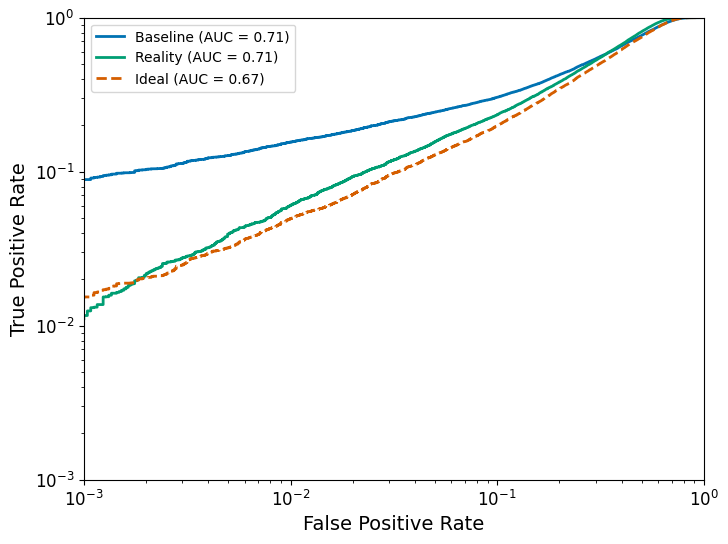

In [26]:
exp_ids = [("CIFAR_top5_l0", "target", "Baseline"),
           ("CIFAR_top5_l5", "target", "Reality"),
           ("CIFAR_top5_l0","target_filt", "Ideal")]


plot_multi_roc(exp_ids)

## Remove top 5%

### CIFAR10

In [ ]:
# ##KD 

# exp_ids = [
#     "wrn28-2_CIFAR_5_l0_kd_temp_2.0_weight_0.5"
# ]

# for exp_id in exp_ids:
#     print("=="*50)
#     print(f"Processing experiment: {exp_id}")
#     tpr = tpr_at_fpr(exp_id, fpr=0.001)
#     print(tpr)
#     saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
#     print(f"Accuracy {saves['test_acc']:.2f}")
#     print(f"Num samples: {len(saves['trained_on_indices'])}")
#     # if "Top 5%" not in pointsvmetrics:
#     #     pointsvmetrics["Top 5%"] = []
#     # pointsvmetrics["Top 5%"].append({
#     #     "tpr": tpr["tpr_at_fpr_0.001"].iloc[0],
#     #     "acc": saves["test_acc"],
#     #     "num_samples": len(saves["trained_on_indices"]),
#     # })


Processing experiment: wrn28-2_CIFAR_5_l0_kd_temp_2.0_weight_0.5
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall  \
0   LiRA           0.00444  111  0.579941   0.822222  0.00444   

   threshold_at_fpr  
0          2.487939  
Accuracy 85.26
Num samples: 25000


Processing experiment: CIFAR_top5_l0
  attack  tpr_at_fpr_0.001   tps      auc  precision  recall  threshold_at_fpr
0   LiRA            0.0882  2205  0.71007   0.989233  0.0882          6.494884
Accuracy 91.29
Num samples: 25000
Processing experiment: CIFAR_top5_l1
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.050232  1193  0.703017   0.980279  0.050232   

   threshold_at_fpr  
0          7.410028  
Accuracy 90.21
Num samples: 23750
Processing experiment: CIFAR_top5_l2
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.036431  822  0.696149   0.971631  0.036431   

   threshold_at_fpr  
0          6.547515  
Accuracy 88.89
Num samples: 22563
Processing experiment: CIFAR_top5_l3
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.030044  644  0.701728   0.964072  0.030044   

   threshold_at_fpr  
0          6.961058  
Accuracy 87.97
Num samples: 21435
Processing experiment: CI

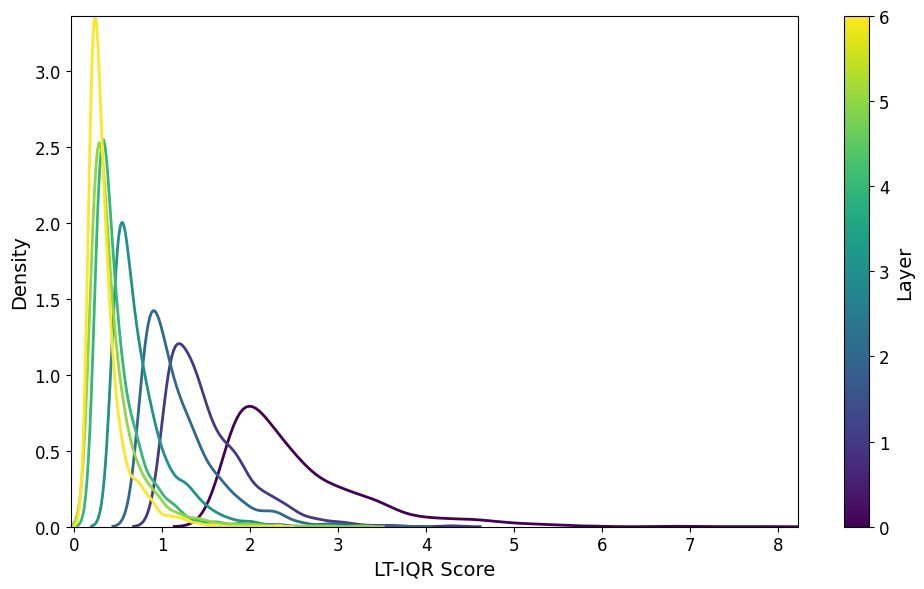

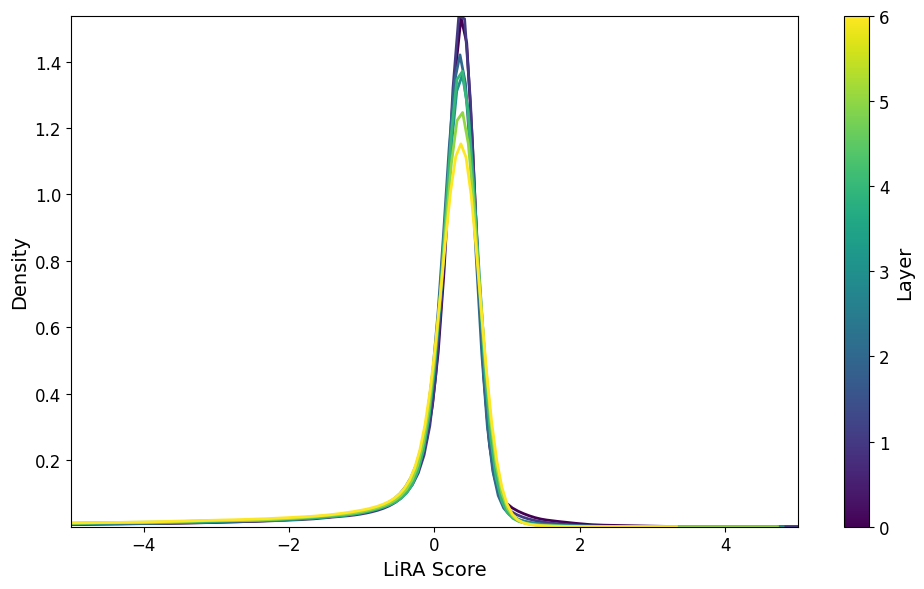

In [12]:
exp_ids = [
    f"CIFAR_top5_l{layer}" for layer in range(7)
]

for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")
    if "Top 5%" not in pointsvmetrics:
        pointsvmetrics["Top 5%"] = []
    pointsvmetrics["Top 5%"].append({
        "tpr": tpr["tpr_at_fpr_0.001"].iloc[0],
        "acc": saves["test_acc"],
        "num_samples": len(saves["trained_on_indices"]),
    })

plot_kde(exp_ids, save_name="iter_removal_cifar5")
plot_kde_lira(exp_ids, save_name="iter_removal_cifar5_lira")


### CINIC10

In [ ]:
# exp_ids = [
#     f"cinictest", "wrn28-2_CINIC_l0"
# ]
# trained_points = {}
# for exp_id in exp_ids:
#     print("=="*50)
#     print(f"Processing experiment: {exp_id}")
#     tpr = tpr_at_fpr(exp_id, fpr=0.001)
#     print(tpr)
#     saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
#     trained_points[exp_id] = saves['trained_on_indices']
#     print(f"Accuracy {saves['test_acc']:.2f}")
#     print(f"Num samples: {len(saves['trained_on_indices'])}")

Processing experiment: cinictest
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.106844  4808  0.772741   0.990932  0.106844   

   threshold_at_fpr  
0          6.470314  
Accuracy 81.23
Num samples: 45000
Processing experiment: wrn28-2_CINIC_l0
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.021578  971  0.628915    0.95665  0.021578   

   threshold_at_fpr  
0         12.597131  
Accuracy 66.83
Num samples: 45000


## Remove top 2.5%

### CIFAR10

Processing experiment: CIFAR_top5_l0
  attack  tpr_at_fpr_0.001   tps      auc  precision  recall  threshold_at_fpr
0   LiRA            0.0882  2205  0.71007   0.989233  0.0882          6.494884
Accuracy 91.29
Num samples: 25000
Processing experiment: CIFAR_top2_l1
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.065641  1600  0.703087   0.985222  0.065641   

   threshold_at_fpr  
0          6.959772  
Accuracy 90.08
Num samples: 24375
Processing experiment: CIFAR_top2_l2
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.056383  1340  0.705492   0.982405  0.056383   

   threshold_at_fpr  
0          7.176099  
Accuracy 89.74
Num samples: 23766
Processing experiment: CIFAR_top2_l3
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.047126  1092  0.701626   0.978495  0.047126   

   threshold_at_fpr  
0          6.734895  
Accuracy 89.34
Num samples: 23172
Processing experiment

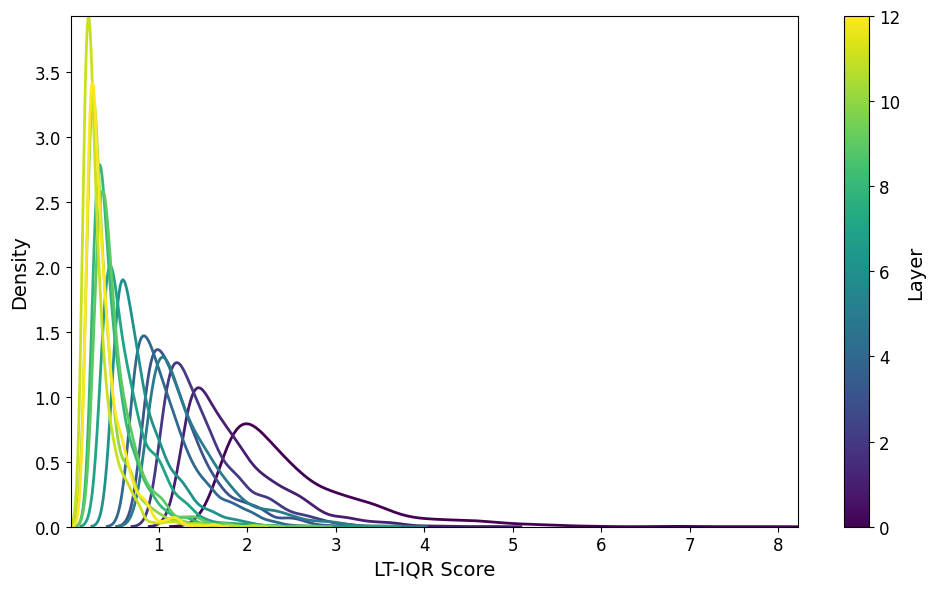

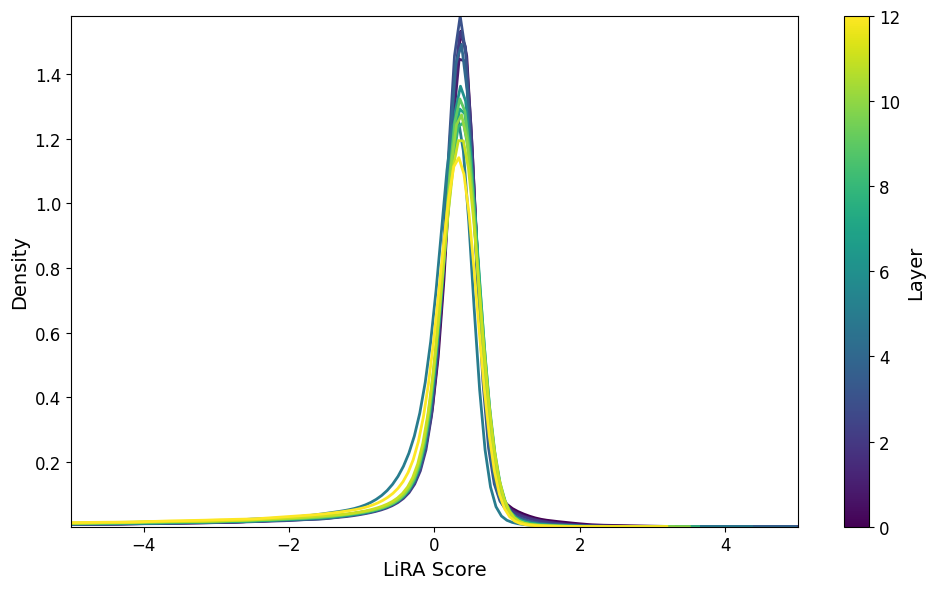

In [13]:
exp_ids = [
    f"CIFAR_top2_l{layer}" for layer in range(1,13)
]
exp_ids.insert(0, "CIFAR_top5_l0")

for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")
    if "Top 2.5%" not in pointsvmetrics:
        pointsvmetrics["Top 2.5%"] = []
    pointsvmetrics["Top 2.5%"].append({
        "tpr": tpr["tpr_at_fpr_0.001"].iloc[0],
        "acc": saves["test_acc"],
        "num_samples": len(saves["trained_on_indices"]),
    })
plot_kde(exp_ids, save_name="iter_removal_cifar2")
plot_kde_lira(exp_ids, save_name="iter_removal_cifar2_lira")


In [2]:
import torch
path = "/vol/bitbucket/vb524/lossv2/trained_models/models/kd/CIFAR_top5_l0_kd_temp_2.0_weight_0.5"
saves = torch.load(path, weights_only=False)
print(f"Accuracy {saves['test_acc']:.2f}")


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

## Gradient Clipping

Processing experiment: wrn28-2_CIFAR10_c_10
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall  \
0   LiRA           0.02832  708  0.656494   0.967213  0.02832   

   threshold_at_fpr  
0         74.792133  
Accuracy 86.01
Processing experiment: wrn28-2_CIFAR10_c_5
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall  \
0   LiRA           0.01348  337  0.636401   0.933518  0.01348   

   threshold_at_fpr  
0         45.092687  
Accuracy 84.05
Processing experiment: wrn28-2_CIFAR10_c_3
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall  \
0   LiRA           0.00776  194  0.620119   0.889908  0.00776   

   threshold_at_fpr  
0         20.596763  
Accuracy 82.38


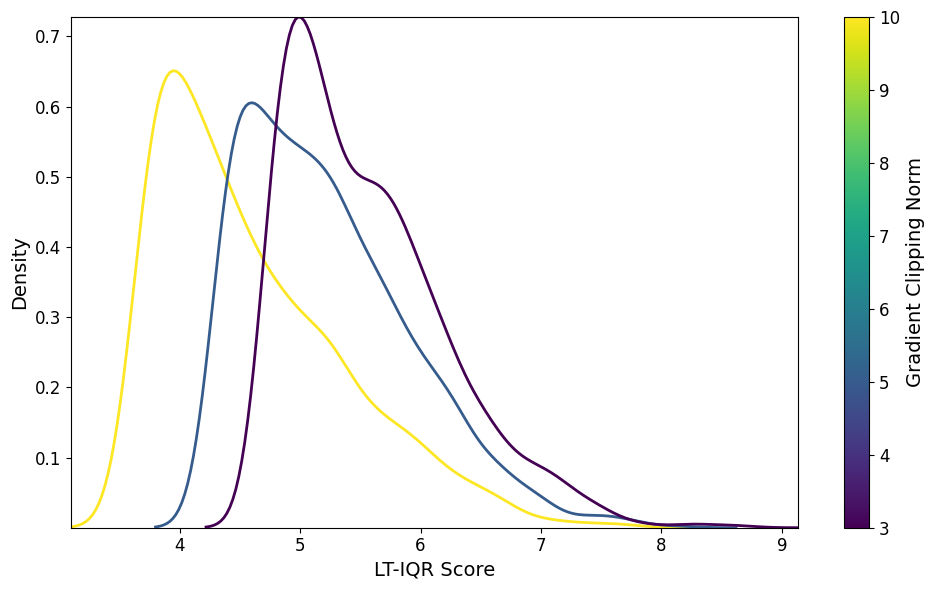

In [ ]:
exp_ids = ["wrn28-2_CIFAR10_c_10", "wrn28-2_CIFAR10_c_5", "wrn28-2_CIFAR10_c_3"]
for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    # plot_roc(exp_id, fpr=0.001, tpr=0.9, plot=True)
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")

plot_kde_custom(exp_ids, labels=[10,5,3 ], label_name="Gradient Clipping Norm", save_name="cifar10_clipping")




In [8]:
exp_ids = ["CIFAR_dp_50ep_10c"]
import torch
for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    # plot_roc(exp_id, fpr=0.001, tpr=0.9, plot=True)
    # tpr = tpr_at_fpr(exp_id, fpr=0.001)
    # print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/shadow_1", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")




Processing experiment: CIFAR_dp_50ep_10c
Accuracy 51.33


### CIFAR RANDOM

Processing experiment: wrn28-2_CIFAR10_rand_l0
  attack  tpr_at_fpr_0.001   tps       auc  precision  recall  \
0   LiRA            0.0556  1390  0.659075   0.983027  0.0556   

   threshold_at_fpr  
0          6.983428  
Accuracy 91.29
Num samples: 25000
Processing experiment: wrn28-2_CIFAR10_rand_l1
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.044589  1059  0.665131   0.977839  0.044589   

   threshold_at_fpr  
0          8.914623  
Accuracy 90.62
Num samples: 23750
Processing experiment: wrn28-2_CIFAR10_rand_l2
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.053672  1211  0.664211   0.980567  0.053672   

   threshold_at_fpr  
0           6.55238  
Accuracy 89.95
Num samples: 22563
Processing experiment: wrn28-2_CIFAR10_rand_l3
  attack  tpr_at_fpr_0.001   tps      auc  precision    recall  \
0   LiRA          0.050571  1084  0.67127   0.978339  0.050571   

   threshold_at_fpr  
0          8.247949  


  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.055619  1076  0.679808   0.978182  0.055619   

   threshold_at_fpr  
0          7.203116  
Accuracy 89.47
Num samples: 19346
Processing experiment: wrn28-2_CIFAR10_rand_l6
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.053703  987  0.685007   0.976261  0.053703   

   threshold_at_fpr  
0          7.666848  
Accuracy 88.97
Num samples: 18379


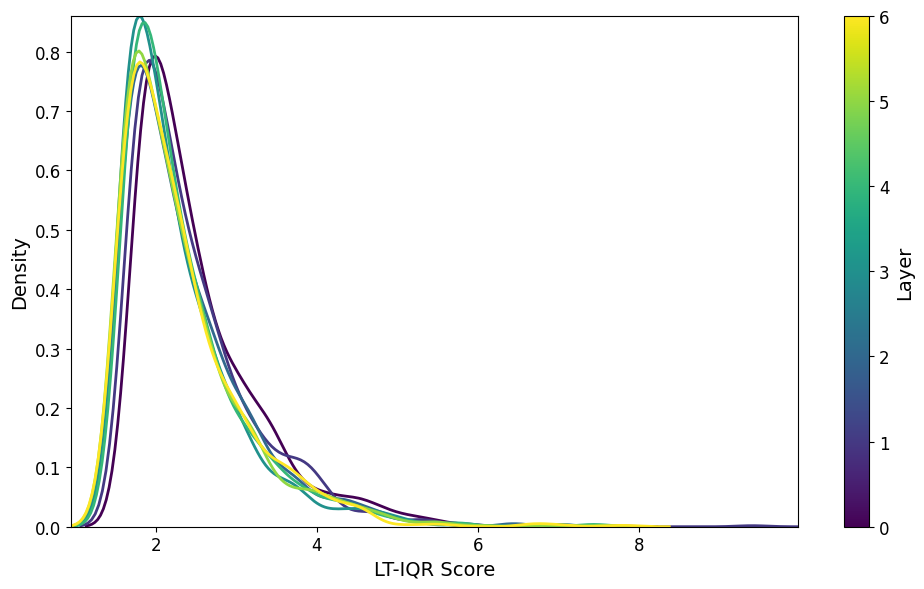

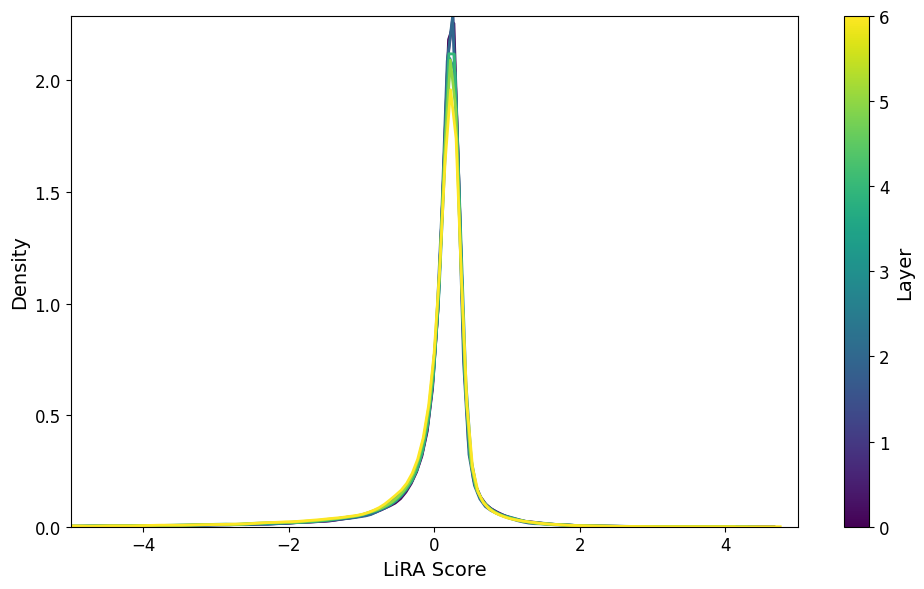

In [8]:
exp_ids = [
    f"wrn28-2_CIFAR10_rand_l{layer}" for layer in range(7)
]
for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")
    if "Random 5%" not in pointsvmetrics:
        pointsvmetrics["Random 5%"] = []
    pointsvmetrics["Random 5%"].append({
        "tpr": tpr["tpr_at_fpr_0.001"].iloc[0],
        "acc": saves["test_acc"],
        "num_samples": len(saves["trained_on_indices"]),
    })

plot_kde(exp_ids, save_name="iter_removal_cifar10_rand")
plot_kde_lira(exp_ids, save_name="iter_removal_cifar10_rand_lira")


In [20]:
import pickle

with open("/vol/bitbucket/vb524/lossv2/trained_models/layer_target_indices/CIFAR_top5/layer_0_vulnerable.pkl", "rb") as f:
    vulnerable_layer_1 = pickle.load(f)
with open("/vol/bitbucket/vb524/lossv2/trained_models/layer_target_indices/CIFAR_top5/layer_2_full_safe.pkl", "rb") as f:
    vulnerable_layer_2 = pickle.load(f)

type(vulnerable_layer_2)

pandas.core.frame.DataFrame

## KD

Processing experiment: kd
  attack  tpr_at_fpr_0.001  tps      auc  precision   recall
0   LiRA           0.00288   72  0.55309       0.75  0.00288
Accuracy 0.88
Num samples: 25000
Processing experiment: kd_0_mask
  attack  tpr_at_fpr_0.001  tps       auc  precision  recall
0   LiRA             0.006  150  0.552061   0.857143   0.006
Accuracy 86.97
Num samples: 25000


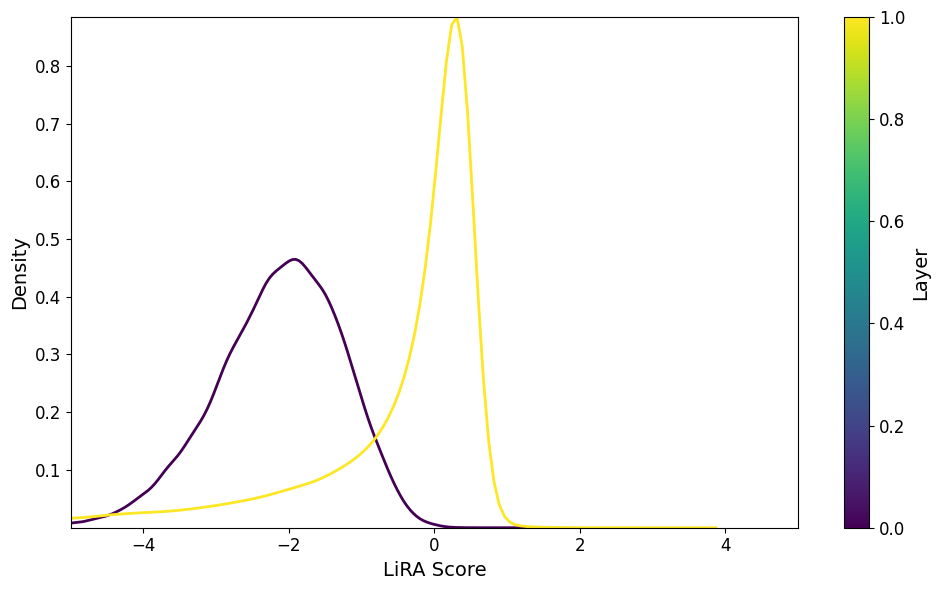

(<Figure size 1000x600 with 2 Axes>,
 <Axes: xlabel='LiRA Score', ylabel='Density'>)

In [ ]:
# exp_ids = [
#     "kd", "kd_0_mask"
# ]
# for exp_id in exp_ids:
#     print("=="*50)
#     print(f"Processing experiment: {exp_id}")
#     tpr = tpr_at_fpr(exp_id, fpr=0.001)
#     print(tpr)
#     saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
#     print(f"Accuracy {saves['test_acc']:.2f}")
#     print(f"Num samples: {len(saves['trained_on_indices'])}")

# # plot_kde_custom(exp_ids, labels=[0.5,0], label_name="Confidence Masking Strength", save_name="cifar10_kd")
# # plot_kde_lira(exp_ids)

## Clustering

In [ ]:
# exp_ids = [
# "wrn28-2_CIFAR10_cluster"
# ]
# for exp_id in exp_ids:
#     print("=="*50)
#     print(f"Processing experiment: {exp_id}")
#     tpr = tpr_at_fpr(exp_id, fpr=0.001)
#     print(tpr)
#     saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
#     print(f"Accuracy {saves['test_acc']:.2f}")
#     print(f"Num samples: {len(saves['trained_on_indices'])}")

Processing experiment: wrn28-2_CIFAR10_cluster
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall
0   LiRA          0.025979  570  0.671479   0.959596  0.025979
Accuracy 86.71
Num samples: 21941


## Trained Points vs Acc and TPR

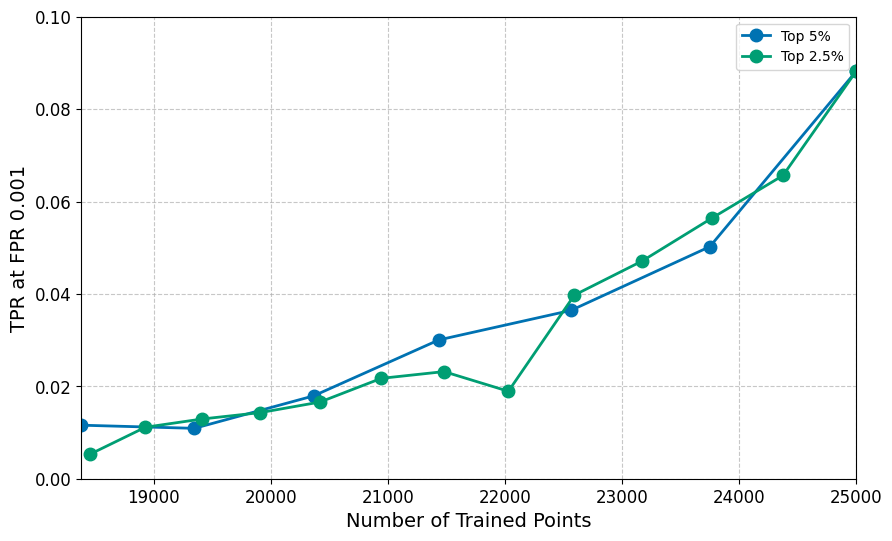

In [14]:
plt.figure(figsize=(10, 6))
for label, metrics in pointsvmetrics.items():
    tpr_values = [m["tpr"] for m in metrics]
    num_samples = [m["num_samples"] for m in metrics]
    plt.plot(num_samples, tpr_values, marker='o', label=label, markersize=9)
plt.xlabel("Number of Trained Points")
plt.ylabel("TPR at FPR 0.001")
plt.legend()
plt.ylim(0,0.1)    
plt.grid(linestyle='--', alpha=0.7)
plt.savefig("./figures/pointsvstpr.png", bbox_inches='tight', dpi=300)



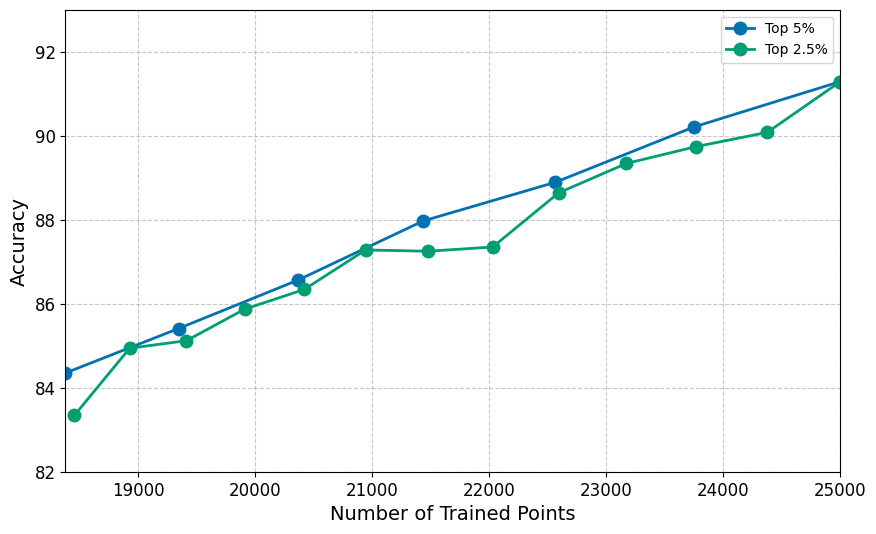

In [15]:
plt.figure(figsize=(10, 6))
for label, metrics in pointsvmetrics.items():
    acc = [m["acc"] for m in metrics]
    num_samples = [m["num_samples"] for m in metrics]
    plt.plot(num_samples, acc, marker='o', label=label, markersize=9)
plt.xlabel("Number of Trained Points")
plt.ylabel("Accuracy")
plt.ylim(82, 93)
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.savefig("./figures/pointsvacc.png", bbox_inches='tight', dpi=300)

In [ ]:
import matplotlib.patches as mpatches
layers = list(range(7))
test_acc = [89.33, 87.22, 86.43, 84.42, 84.03, 81.04, 80.33]
tpr_0_001 = [0.0468, 0.0197, 0.0103, 0.0093, 0.0107, 0.0071, 0.0029]
points = [25000, 23750, 22563, 21435,20364,19346,18379]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(test_acc, tpr_0_001, layers, marker='X', linestyle='', markersize=15)
# plt.legend(layers, title='Layers', loc='upper right')

# # Label points by layer
for acc, tpr, layer in zip(points, tpr_0_001, layers):
    plt.text(
        acc + 0.05,
        tpr + 0.0034,
        f'{layer}',
        fontsize=12,
        ha='left',
        va='top',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='red', alpha=0.25)
    )

# Add legend explaining the red box
red_patch = mpatches.Patch(color='red', alpha=0.25, label='Layer number (in red box)')
plt.legend(handles=[red_patch], loc='lower right')


# Labels and title
plt.xlabel('Traning Points')
plt.ylabel('TPR @ 0.001 FPR')
# plt.xlim(80, 90)
# plt.ylim(0, 0.05)
plt.box(False)
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)
# plt.tight_layout()
plt.show()

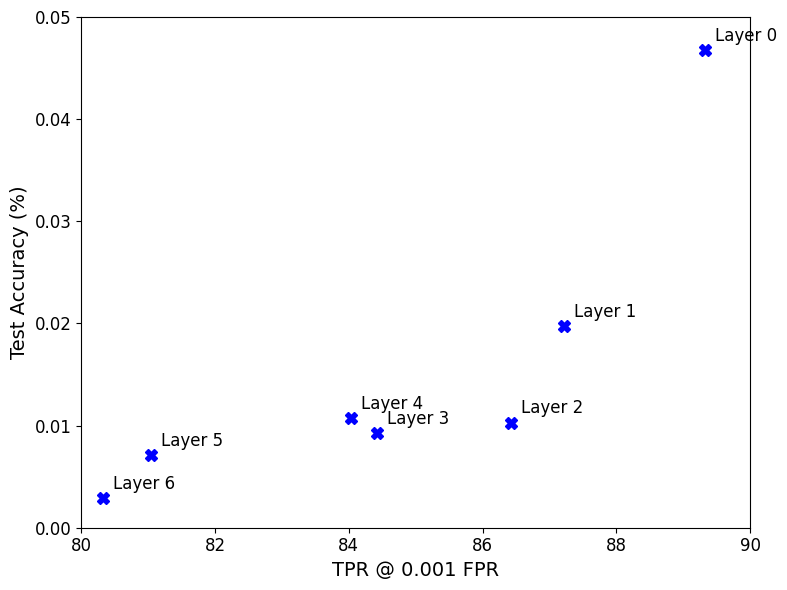

In [11]:

layers = list(range(7))
test_acc = [89.33, 87.22, 86.43, 84.42, 84.03, 81.04, 80.33]
tpr_0_001 = [0.0468, 0.0197, 0.0103, 0.0093, 0.0107, 0.0071, 0.0029]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(test_acc, tpr_0_001, marker='X', linestyle='', color='blue', markersize=8)

# Label points by layer
for acc, tpr, layer in zip(test_acc, tpr_0_001, layers):
    plt.text(acc+0.15, tpr+0.0005,f'Layer {layer}', fontsize=12, ha='left', va='bottom' )

# Labels and title
plt.ylabel('Test Accuracy (%)')
plt.xlabel('TPR @ 0.001 FPR')
plt.ylim(0, 0.05)
plt.xlim(80, 90)
plt.tight_layout()
plt.show()